# Tensor Puzzles
- by [Sasha Rush](http://rush-nlp.com) - [srush_nlp](https://twitter.com/srush_nlp) (with Marcos Treviso)





When learning a tensor programming language like PyTorch or Numpy it
is tempting to rely on the standard library (or more honestly
StackOverflow) to find a magic function for everything.  But in
practice, the tensor language is extremely expressive, and you can
do most things from first principles and clever use of broadcasting.



This is a collection of 21 tensor puzzles. Like chess puzzles these are
not meant to simulate the complexity of a real program, but to practice
in a simplified environment. Each puzzle asks you to reimplement one
function in the NumPy standard library without magic.


I recommend running in Colab. Click here and copy the notebook to get start.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/srush/Tensor-Puzzles/blob/main/Tensor%20Puzzlers.ipynb)

In [1]:
!pip install -qqq torchtyping hypothesis pytest git+https://github.com/chalk-diagrams/chalk
!wget -q https://github.com/srush/Tensor-Puzzles/raw/main/lib.py

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.2/465.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 58.3 MB/s eta 0:00:00


In [2]:
from lib import draw_examples, make_test, run_test
import torch
import numpy as np
from torchtyping import TensorType as TT
tensor = torch.tensor

## Rules

1. These puzzles are about *broadcasting*. Know this rule.

![](https://pbs.twimg.com/media/FQywor0WYAssn7Y?format=png&name=large)

2. Each puzzle needs to be solved in 1 line (<80 columns) of code.
3. You are allowed @, arithmetic, comparison, `shape`, any indexing (e.g. `a[:j], a[:, None], a[arange(10)]`), and previous puzzle functions.
4. You are *not allowed* anything else. No `view`, `sum`, `take`, `squeeze`, `tensor`.

5. You can start with these two functions:

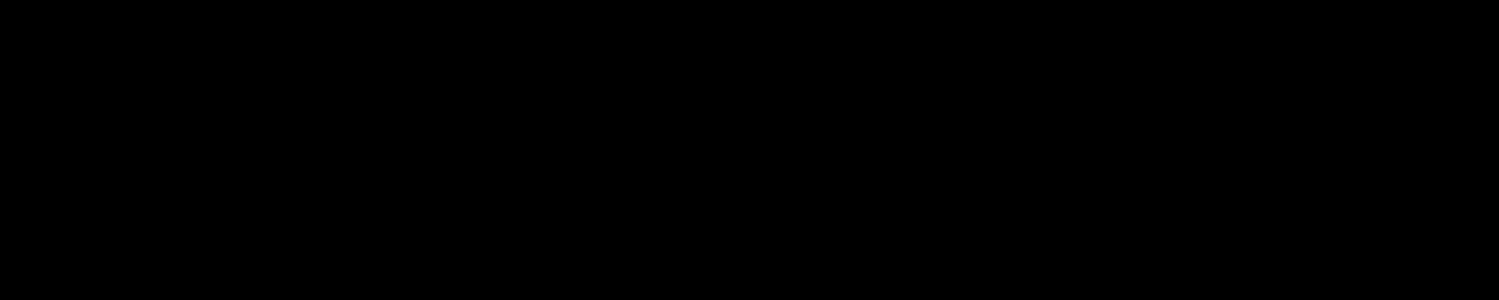

In [3]:
def arange(i: int):
    "Use this function to replace a for-loop."
    return torch.tensor(range(i))

draw_examples("arange", [{"" : arange(i)} for i in [5, 3, 9]])

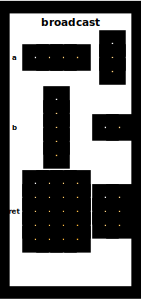

In [4]:
# Example of broadcasting.Copy of
examples = [(arange(4), arange(5)[:, None]) ,
            (arange(3)[:, None], arange(2))]
draw_examples("broadcast", [{"a": a, "b":b, "ret": a + b} for a, b in examples])

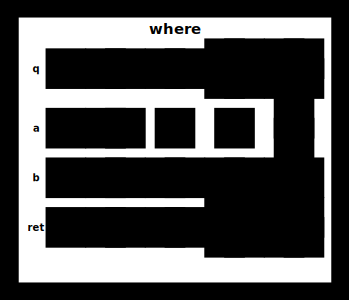

In [5]:
def where(q, a, b):
    "Use this function to replace an if-statement."
    return (q * a) + (~q) * b

# In diagrams, orange is positive/True, white is zero/False, and blue is negative.

examples = [(tensor([False]), tensor([10]), tensor([5])),
            (tensor([False, True]), tensor([1, 1]), tensor([-10, 0])),
            (tensor([False, True]), tensor([1]), tensor([-10, 0])),
            (tensor([[False, True], [True, False]]), tensor([1]), tensor([-10, 0])),
            (tensor([[False, True], [True, False]]), tensor([[0], [10]]), tensor([-10, 0])),
           ]
draw_examples("where", [{"q": q, "a":a, "b":b, "ret": where(q, a, b)} for q, a, b in examples])

## Puzzle 1 - ones

Compute [ones](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) - the vector of all ones.

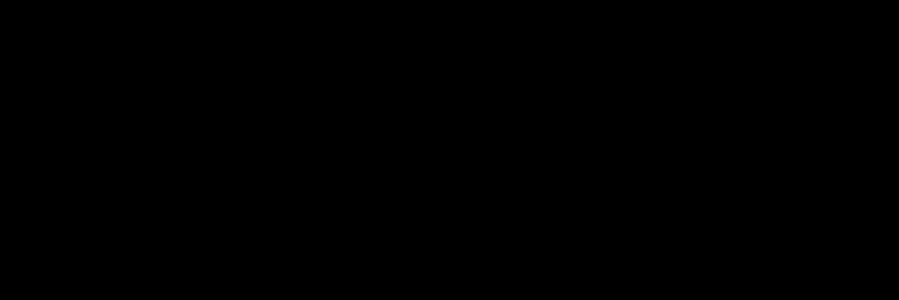

In [6]:
def ones_spec(out):
    for i in range(len(out)):
        out[i] = 1

def ones(i: int) -> TT["i"]:
    return where(True, arange(i), arange(i))+arange(i)+1

test_ones = make_test("one", ones, ones_spec, add_sizes=["i"])

In [ ]:
run_test(test_ones)

Correct!


## Puzzle 2 - sum

Compute [sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) - the sum of a vector.

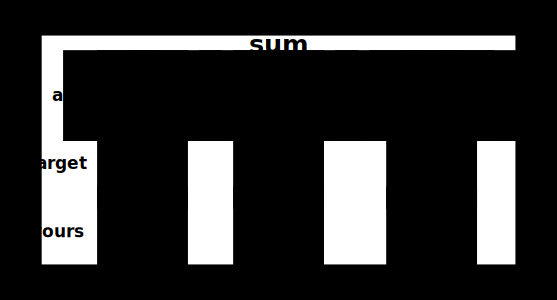

In [7]:
def sum_spec(a, out):
    out[0] = 0
    for i in range(len(a)):
        out[0] += a[i]

def sum(a: TT["i"]) -> TT[1]:
    return a @ ones(a.shape[0])+arange(1)

# sum(tensor([1,2,3]))
test_sum = make_test("sum", sum, sum_spec)

In [ ]:
run_test(test_sum)

Correct!


In [ ]:
a = tensor([1,2,3,4])
b = a @ ones(a.shape[0])
print(b)

tensor(10)


## Puzzle 3 - outer

Compute [outer](https://numpy.org/doc/stable/reference/generated/numpy.outer.html) - the outer product of two vectors.

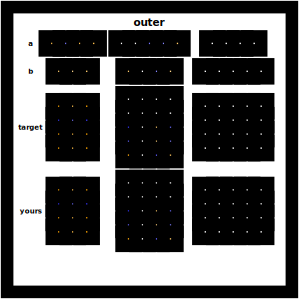

In [8]:
def outer_spec(a, b, out):
    for i in range(len(out)):
        for j in range(len(out[0])):
            out[i][j] = a[i] * b[j]

def outer(a: TT["i"], b: TT["j"]) -> TT["i", "j"]:
    # return a[:, None] * b
    return a[:, None] @ b[None, :]

test_outer = make_test("outer", outer, outer_spec)

In [ ]:
arange(3)[:, None] @ arange(3)[None, :]

tensor([[0, 0, 0],
        [0, 1, 2],
        [0, 2, 4]])

In [ ]:
run_test(test_outer)

Correct!


## Puzzle 4 - diag

Compute [diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html) - the diagonal vector of a square matrix.

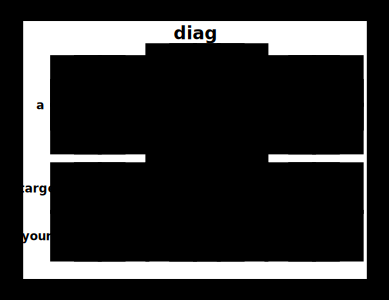

In [9]:
def diag_spec(a, out):
    for i in range(len(a)):
        out[i] = a[i][i]

def diag(a: TT["i", "i"]) -> TT["i"]:
    return a[arange(a.shape[0]), arange(a.shape[0])]


test_diag = make_test("diag", diag, diag_spec)

In [ ]:
a = tensor([[1,2, 3], [3, 4, 5], [6,7,8]])
arange(a.shape[0])==a.shape[0]-1

tensor([False, False,  True])

In [ ]:
where(outer(ones(a.shape[0]), ones(a.shape[0])), ones(a.shape[0]), ones(a.shape[0]))

tensor([-1, -1, -1])

In [ ]:
diag(outer(ones(3), ones(3)))

tensor([1, 1, 1])

In [ ]:
run_test(test_diag)

Correct!


## Puzzle 5 - eye

Compute [eye](https://numpy.org/doc/stable/reference/generated/numpy.eye.html) - the identity matrix.

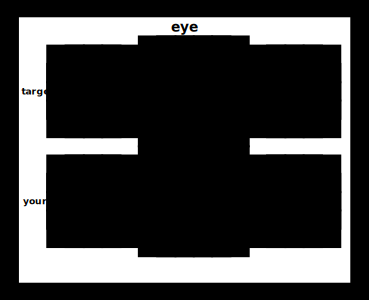

In [10]:
def eye_spec(out):
    for i in range(len(out)):
        out[i][i] = 1

def eye(j: int) -> TT["j", "j"]:
    return where(arange(j)[:, None]-arange(j)[None, :]==0, 1, 0)

test_eye = make_test("eye", eye, eye_spec, add_sizes=["j"])

In [ ]:
where(ones(3), arange(1), arange(1))
zeros = where(outer(ones(3), ones(3)), 0, 0)
one_m = outer(arange(3), arange(3))
new_m = one_m[arange(3), arange(3)] == 4
new_m

tensor([False, False,  True])

In [ ]:
inter = arange(3)[:, None]+arange(3)[None, :]
inter

tensor([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4]])

In [ ]:
run_test(test_eye)

Correct!


## Puzzle 6 - triu

Compute [triu](https://numpy.org/doc/stable/reference/generated/numpy.triu.html) - the upper triangular matrix.

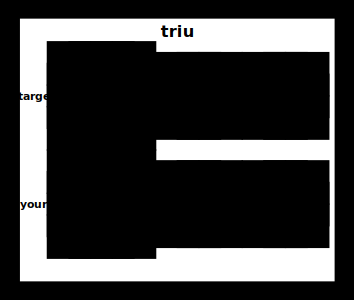

In [ ]:
def triu_spec(out):
    for i in range(len(out)):
        for j in range(len(out)):
            if i <= j:
                out[i][j] = 1
            else:
                out[i][j] = 0

def triu(j: int) -> TT["j", "j"]:
    return where(arange(j)[:, None]-arange(j)[None, :]<=0, 1, 0)


test_triu = make_test("triu", triu, triu_spec, add_sizes=["j"])

In [ ]:
run_test(test_triu)

Correct!


## Puzzle 7 - cumsum

Compute [cumsum](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) - the cumulative sum.

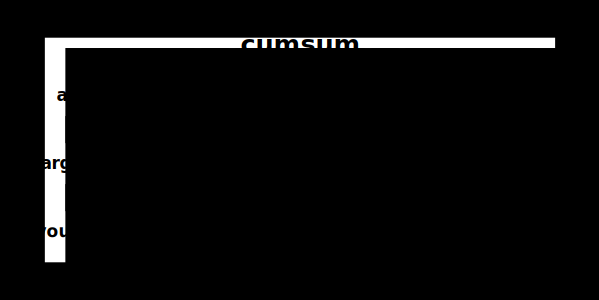

In [11]:
def cumsum_spec(a, out):
    total = 0
    for i in range(len(out)):
        out[i] = total + a[i]
        total += a[i]

def cumsum(a: TT["i"]) -> TT["i"]:
    return where(arange(a.shape[0])[:,None]-arange(a.shape[0])[None,:]>=0,1,0)@a

test_cumsum = make_test("cumsum", cumsum, cumsum_spec)

In [ ]:
run_test(test_cumsum)

Correct!


## Puzzle 8 - diff

Compute [diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html) - the running difference.

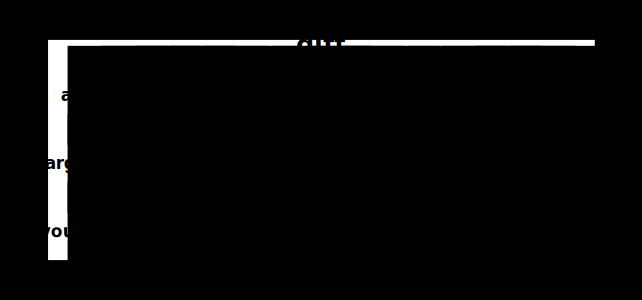

In [ ]:
def diff_spec(a, out):
    out[0] = a[0]
    for i in range(1, len(out)):
        out[i] = a[i] - a[i - 1]

def diff(a: TT["i"], i: int) -> TT["i"]:
    # return (where(arange(i)[:, None]-arange(i)[None, :]==1, -1, 0)+eye(i))@a
    return a - where(arange(i)!=0, a[arange(i)-1], 0)

test_diff = make_test("diff", diff, diff_spec, add_sizes=["i"])

In [ ]:
run_test(test_diff)

Correct!


## Puzzle 9 - vstack

Compute [vstack](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) - the matrix of two vectors

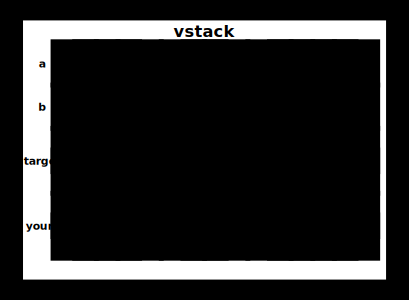

In [12]:
def vstack_spec(a, b, out):
    for i in range(len(out[0])):
        out[0][i] = a[i]
        out[1][i] = b[i]

def vstack(a: TT["i"], b: TT["i"]) -> TT[2, "i"]:
    return where(tensor([[True], [False]]), a, b)


test_vstack = make_test("vstack", vstack, vstack_spec)

In [ ]:
a = tensor([1,2,3,4])
b = tensor([5,6,7,8])
where(tensor([[True], [False]]), a, b)

tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])

In [ ]:
run_test(test_vstack)

Correct!


## Puzzle 10 - roll

Compute [roll](https://numpy.org/doc/stable/reference/generated/numpy.roll.html) - the vector shifted 1 circular position.

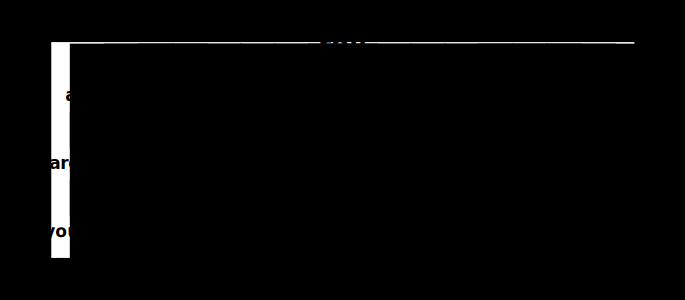

In [ ]:
def roll_spec(a, out):
    for i in range(len(out)):
        if i + 1 < len(out):
            out[i] = a[i + 1]
        else:
            out[i] = a[i + 1 - len(out)]

def roll(a: TT["i"], i: int) -> TT["i"]:
    # return (1*(arange(i)[:,None]-arange(i)==-1)+1*(arange(i)[:,None]-arange(i)==i-1))@a
    return a[(arange(i)+1) % i]


test_roll = make_test("roll", roll, roll_spec, add_sizes=["i"])

In [ ]:
run_test(test_roll)

Correct!


## Puzzle 11 - flip

Compute [flip](https://numpy.org/doc/stable/reference/generated/numpy.flip.html) - the reversed vector

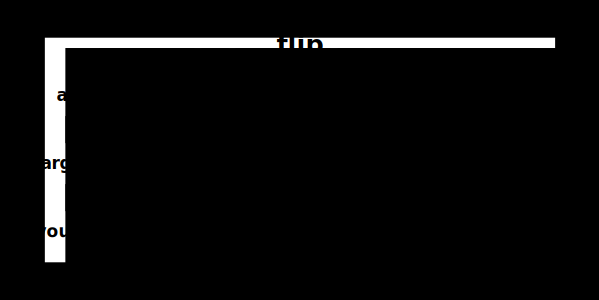

In [ ]:
def flip_spec(a, out):
    for i in range(len(out)):
        out[i] = a[len(out) - i - 1]

def flip(a: TT["i"], i: int) -> TT["i"]:
    # return 1*(arange(i)[:, None]+arange(i)==i-1)@a
    return a[i-1-arange(i)]


test_flip = make_test("flip", flip, flip_spec, add_sizes=["i"])

In [ ]:
run_test(test_flip)

Correct!


## Puzzle 12 - compress


Compute [compress](https://numpy.org/doc/stable/reference/generated/numpy.compress.html) - keep only masked entries (left-aligned).

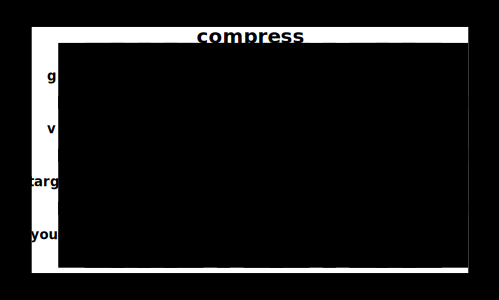

In [36]:
def compress_spec(g, v, out):
    j = 0
    for i in range(len(g)):
        if g[i]:
            out[j] = v[i]
            j += 1

def compress(g: TT["i", bool], v: TT["i"], i:int) -> TT["i"]:
    # zeros = 1*(ones(i)[:, None] != ones(i))
    # indices = sum(1*g)[0]
    # if indices>0:
    #   zeros[arange(indices), arange(i)[g]]=1
    # return zeros@where(g, v, 0)
    return v@ where(g[:, None], arange(i)==(cumsum(1*g)-1)[:, None], 0)



test_compress = make_test("compress", compress, compress_spec, add_sizes=["i"])

In [40]:
g = tensor([True, False, True, False, True])
v = tensor([5,6,7,8, 9])
i = len(g)
# zeros = 1*(ones(i)[:, None]!=ones(i)[None, :])
# zeros[arange(i)][(cumsum(1-1*g)+arange(i))%4]=1
# zeros
# cumsum(1-1*flip(g, 4))
indices = sum(1*g)[0]
arange(i)[arange(indices), None]==arange(i)[None, arange(i)[g]]
where(g[:, None], arange(i)==(cumsum(1*g)-1)[:, None], -1)
v[:3]

tensor([5, 6, 7])

In [ ]:
zeros = 1*(ones(4)!=ones(4))
zeros[arange(sum(1*g))] = v[g]
zeros

tensor([5, 8, 0, 0])

In [ ]:
i = 3
transform = 1*(arange(i)[:, None] - arange(i)[None, :]>i)
v = tensor([True, False, True])
# print(transform)
print(cumsum(where(v, 0, 1)))
# print(arange(i))
print(where((arange(i)+cumsum(where(v, 0, 1)))<i, arange(i)+cumsum(where(v, 0, 1)), i-1))
transform[arange(i)][arange(i)+cumsum(where(v, 0, 1))<i] = 1
print(transform)

tensor([0, 1, 1])
tensor([0, 2, 2])
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])


In [37]:
run_test(test_compress)

Correct!


## Puzzle 13 - pad_to


Compute pad_to - eliminate or add 0s to change size of vector.

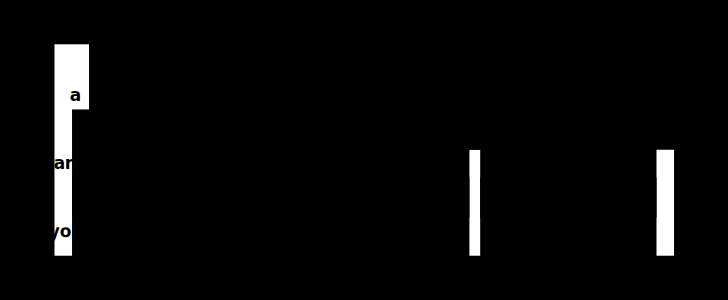

In [52]:
def pad_to_spec(a, out):
    for i in range(min(len(out), len(a))):
        out[i] = a[i]


def pad_to(a: TT["i"], i: int, j: int) -> TT["j"]:
    # if i>=j: return a[:j]
    # else:
    #   zeros = 1*(ones(j)!=ones(j))
    #   zeros[:i] = a
    #   return zeros
    return a @(1*(arange(i)[:, None]==arange(j)))


test_pad_to = make_test("pad_to", pad_to, pad_to_spec, add_sizes=["i", "j"])

In [50]:
a = tensor([3,5,6,7,8])
i = 5
j = 8
a @(1*(arange(i)[:, None]==arange(j)))


tensor([3, 5, 6, 7, 8, 0, 0, 0])

In [53]:
run_test(test_pad_to)

Correct!


## Puzzle 14 - sequence_mask


Compute [sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) - pad out to length per batch.

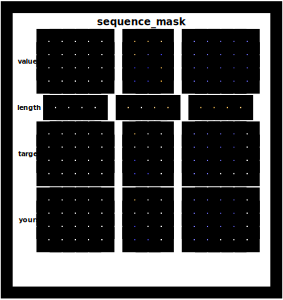

In [66]:
def sequence_mask_spec(values, length, out):
    for i in range(len(out)):
        for j in range(len(out[0])):
            if j < length[i]:
                out[i][j] = values[i][j]
            else:
                out[i][j] = 0

def sequence_mask(values: TT["i", "j"], length: TT["i", int]) -> TT["i", "j"]:
    return (1*(length[:, None]>arange(values[0].shape[0])))*values


def constraint_set_length(d):
    d["length"] = d["length"] % d["values"].shape[1]
    return d


test_sequence = make_test("sequence_mask",
    sequence_mask, sequence_mask_spec, constraint=constraint_set_length
)

In [62]:
length = tensor([1,3,2,3,2])
j = 4
i = 5
length[:, None]>arange(j)

tensor([[ True, False, False, False],
        [ True,  True,  True, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True, False, False]])

In [67]:
run_test(test_sequence)

Correct!


## Puzzle 15 - bincount

Compute [bincount](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) - count number of times an entry was seen.

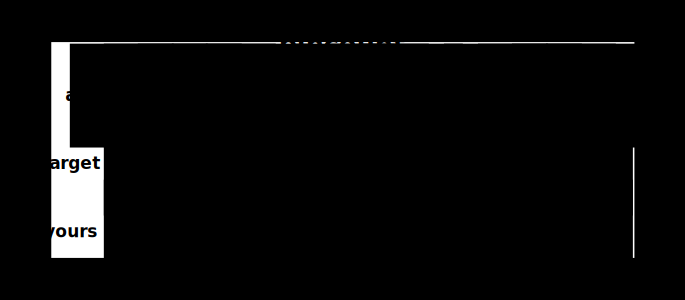

In [ ]:
def bincount_spec(a, out):
    for i in range(len(a)):
        out[a[i]] += 1

def bincount(a: TT["i"], j: int) -> TT["j"]:
    return 1*(arange(j)[:, None] == a[None, :])@ones(a.shape[0])


def constraint_set_max(d):
    d["a"] = d["a"] % d["return"].shape[0]
    return d


test_bincount = make_test("bincount",
    bincount, bincount_spec, add_sizes=["j"], constraint=constraint_set_max
)

In [ ]:
j = 8
a = tensor([0, 1, 1, 3, 2, 1, 7])
print(ones(a.shape[0]))
print(1*(arange(j)[:, None] == a[None, :]))
1*(arange(j)[:, None] == a[None, :])@ones(a.shape[0])

tensor([1, 1, 1, 1, 1, 1, 1])
tensor([[1, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]])


tensor([1, 3, 1, 1, 0, 0, 0, 1])

In [ ]:
run_test(test_bincount)

Correct!


## Puzzle 16 - scatter_add

Compute [scatter_add](https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/add.html) - add together values that link to the same location.

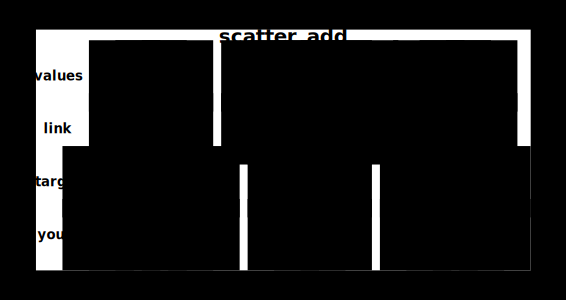

In [ ]:
def scatter_add_spec(values, link, out):
    for j in range(len(values)):
        out[link[j]] += values[j]

def scatter_add(values: TT["i"], link: TT["i"], j: int) -> TT["j"]:
    return values@(1*(arange(j)[None, :]==link[:,None]))


def constraint_set_max(d):
    d["link"] = d["link"] % d["return"].shape[0]
    return d


test_scatter_add = make_test("scatter_add",
    scatter_add, scatter_add_spec, add_sizes=["j"], constraint=constraint_set_max
)

In [ ]:
values = tensor([1,3,4,5,7,8,3,6])
link = tensor([0,2,1,0,3,1,2,3])
j = 4
print(values*ones(j)[:, None])
print(1*(arange(j)[None, :] == link[:, None]))
values@(1*(arange(j)[None, :] == link[:, None]))

tensor([[1, 3, 4, 5, 7, 8, 3, 6],
        [1, 3, 4, 5, 7, 8, 3, 6],
        [1, 3, 4, 5, 7, 8, 3, 6],
        [1, 3, 4, 5, 7, 8, 3, 6]])
tensor([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])


tensor([ 6, 12,  6, 13])

In [ ]:
run_test(test_scatter_add)

Correct!


## Puzzle 17 - flatten

Compute [flatten](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html)

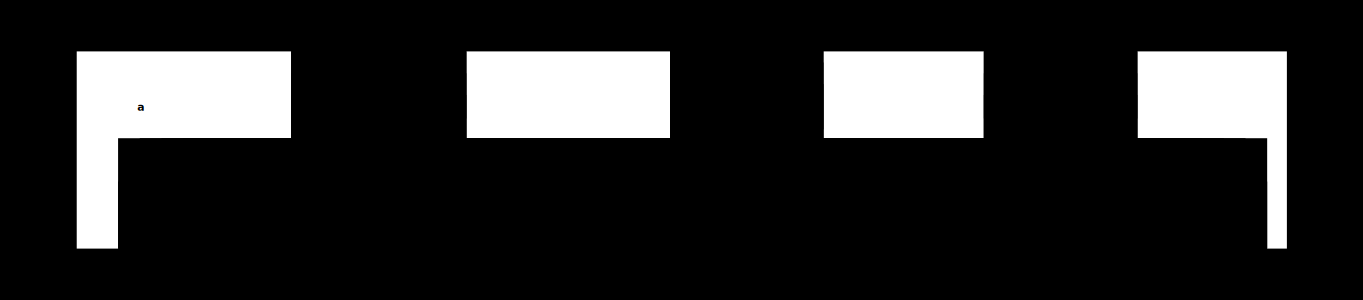

In [41]:
def flatten_spec(a, out):
    k = 0
    for i in range(len(a)):
        for j in range(len(a[0])):
            out[k] = a[i][j]
            k += 1

def flatten(a: TT["i", "j"], i:int, j:int) -> TT["i * j"]:
    return a[arange(i*j)//j, arange(i*j)%j]

test_flatten = make_test("flatten", flatten, flatten_spec, add_sizes=["i", "j"])

In [40]:
i = 4
j = 3
# one_m = 1*(ones(i)[:, None]==ones(i)[None, :])
# zeros = 1*(ones(i*i)!=ones(i*i))
# print(zeros)
# print(one_m)
a = tensor([[0,3,4], [3,5,9], [2,8,4], [2,3,4]])
(arange(i*j))[None, :]%(j*ones(j))[:, None]
print(a @ (1*((arange(i*j)[None, :]-cumsum(arange(j))[:, None])%j==0)))
print(arange(i*j)//j)
print(arange(i*j)%j)
print(a[arange(i*j)//j, arange(i*j)%j])

tensor([[ 4,  3,  0,  4,  3,  0,  4,  3,  0,  4,  3,  0],
        [12,  5,  0, 12,  5,  0, 12,  5,  0, 12,  5,  0],
        [ 6,  8,  0,  6,  8,  0,  6,  8,  0,  6,  8,  0],
        [ 6,  3,  0,  6,  3,  0,  6,  3,  0,  6,  3,  0]])
tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])
tensor([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])
tensor([0, 3, 4, 3, 5, 9, 2, 8, 4, 2, 3, 4])


In [42]:
run_test(test_flatten)

Correct!


## Puzzle 18 - linspace

Compute [linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)

<ipython-input-60-352389cc4019>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-60-352389cc4019>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-60-352389cc4019>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))


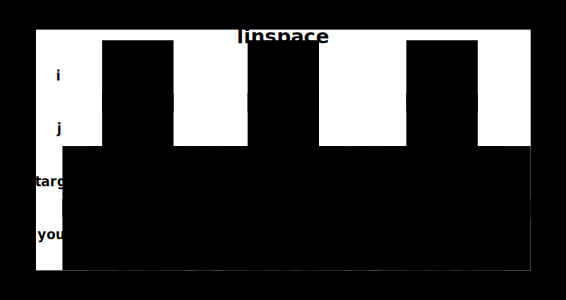

In [ ]:
def linspace_spec(i, j, out):
    for k in range(len(out)):
        out[k] = float(i + (j - i) * k / max(1, len(out) - 1))

def linspace(i: TT[1], j: TT[1], n: int) -> TT["n", float]:
    return i+((j-i)/max((n-1), 1))*arange(n)

test_linspace = make_test("linspace", linspace, linspace_spec, add_sizes=["n"])

In [ ]:
run_test(test_linspace)

<ipython-input-99-8e22d329e64c>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-99-8e22d329e64c>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-99-8e22d329e64c>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-99-8e22d329e64c>:3: DeprecationWarning: Conver

Correct!


<ipython-input-99-8e22d329e64c>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-99-8e22d329e64c>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-99-8e22d329e64c>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = float(i + (j - i) * k / max(1, len(out) - 1))
<ipython-input-99-8e22d329e64c>:3: DeprecationWarning: Conver

In [ ]:
i = 0
j = 12
n = 6
i+(j-i)*arange(n)/(n-1)

tensor([ 0.0000,  2.4000,  4.8000,  7.2000,  9.6000, 12.0000])

## Puzzle 19 - heaviside

Compute [heaviside](https://numpy.org/doc/stable/reference/generated/numpy.heaviside.html)

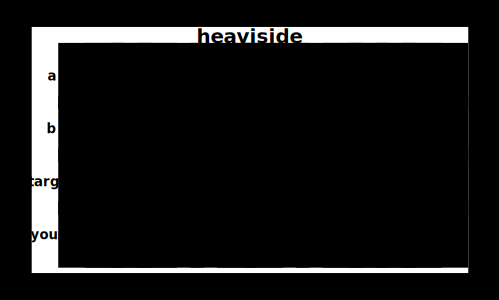

In [ ]:
def heaviside_spec(a, b, out):
    for k in range(len(out)):
        if a[k] == 0:
            out[k] = b[k]
        else:
            out[k] = int(a[k] > 0)

def heaviside(a: TT["i"], b: TT["i"]) -> TT["i"]:
    return where(a==0, b, 1*(a>0))

test_heaviside = make_test("heaviside", heaviside, heaviside_spec)

In [ ]:
run_test(test_heaviside)

Correct!


## Puzzle 20 - repeat (1d)

Compute [repeat](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html)

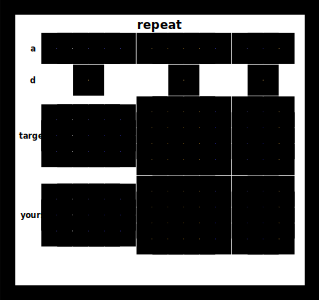

In [89]:
def repeat_spec(a, d, out):
    for i in range(d[0]):
        for k in range(len(a)):
            out[i][k] = a[k]

def constraint_set(d):
    d["d"][0] = d["return"].shape[0]
    return d


def repeat(a: TT["i"], d: TT[1]) -> TT["d", "i"]:
    return a*(ones(d[0])[:, None])

test_repeat = make_test("repeat", repeat, repeat_spec, constraint=constraint_set)


# ## Puzzle 21 - bucketize
#
# Compute [bucketize](https://pytorch.org/docs/stable/generated/torch.bucketize.html)

In [85]:
d = 4
j = 5
1*((arange(d*j)[None, :]-arange(j)[:, None])%j==0)

tensor([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]])

In [ ]:
def bucketize_spec(v, boundaries, out):
    for i, val in enumerate(v):
        out[i] = 0
        for j in range(len(boundaries)-1):
            if val >= boundaries[j]:
                out[i] = j + 1
        if val >= boundaries[-1]:
            out[i] = len(boundaries)


def constraint_set(d):
    d["boundaries"] = np.abs(d["boundaries"]).cumsum()
    return d


def bucketize(v: TT["i"], boundaries: TT["j"]) -> TT["i"]:
    return boundaries.shape[0]-1*(boundaries[None, :]>v[:, None])@ones(boundaries.shape[0])

test_bucketize = make_test("bucketize", bucketize, bucketize_spec,
                           constraint=constraint_set)


#
# # Speed Run Mode!
#
# What is the smallest you can make each of these?

KeyboardInterrupt: 

In [ ]:
boundaries = tensor([1,3,5,7,9])
v = tensor([3, 6, 9])
5-1*(boundaries[None, :]>v[:, None])@ones(5)

tensor([2, 3, 5])

In [ ]:
import inspect
fns = (ones, sum, outer, diag, eye, triu, cumsum, diff, vstack, roll, flip,
       compress, pad_to, sequence_mask, bincount, scatter_add)

for fn in fns:
    lines = [l for l in inspect.getsource(fn).split("\n") if not l.strip().startswith("#")]

    if len(lines) > 3:
        print(fn.__name__, len(lines[2]), "(more than 1 line)")
    else:
        print(fn.__name__, len(lines[1]))

ones 29
sum 29
outer 29
diag 29
eye 29
triu 29
cumsum 29
diff 29
vstack 29
roll 29
flip 29
compress 29
pad_to 29
sequence_mask 29
bincount 29
scatter_add 29
